# NE 204 Lab 2

Devin Thatcher

In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths

Comparing the timestamps, raw waveforms, filtered pulses, and spectra of Co-60 between the HPGe, NaI, and EJ309 detectors

## Timestamps

In [231]:
def Timestamps(filelocation):
    with h5py.File(filelocation, 'r') as f:
        data = np.array(f['event_data'])
        eventdata = pd.DataFrame(data)
        eventtime = eventdata['timestamp']/250000000
        eventtime.plot()
        plt.xlabel('Event #')
        plt.ylabel('Time passed in seconds')

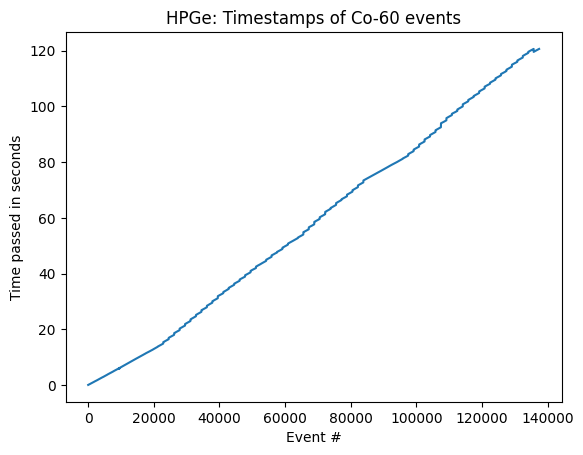

In [232]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\HPGe\Co60_120s.h5"
Timestamps(filelocation)
plt.title('HPGe: Timestamps of Co-60 events')
plt.show()

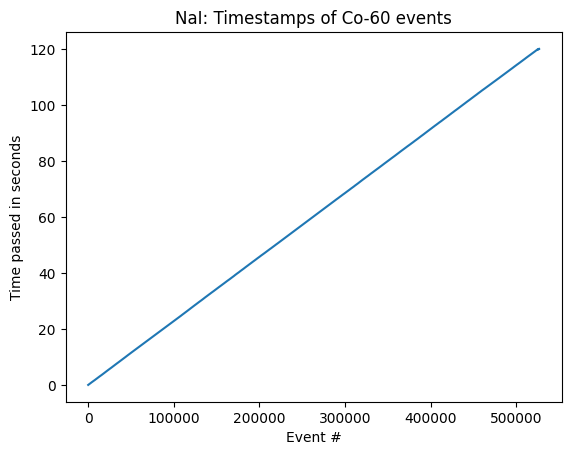

In [233]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\NaI\Co60\NaI_Co60_120s.h5"
Timestamps(filelocation)
plt.title('NaI: Timestamps of Co-60 events')
plt.show()

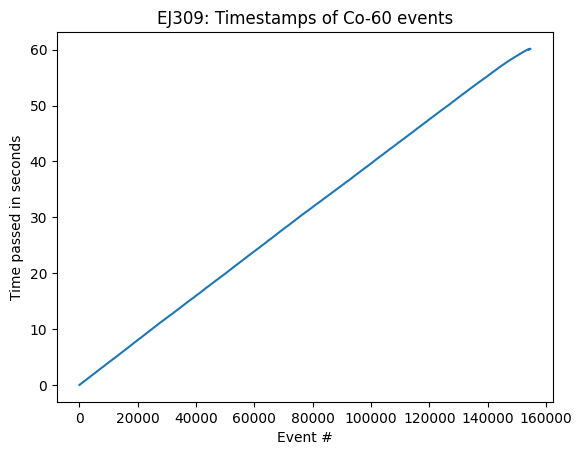

In [234]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\EJ309\EJ309_Co60_60s.h5"
Timestamps(filelocation)
plt.title('EJ309: Timestamps of Co-60 events')
plt.show()

Not too much to see here, events were recorded at a linear rate for both scintillators, and a mostly linear rate for the HPGe.

## Raw Waveforms

In [235]:
def Pulses(filelocation, events, XRange, preTrgrDly):
    with h5py.File(filelocation, 'r') as f:
        for a in range(0, events):
            pulse = np.array(f['raw_data'][a, :XRange])  # type: ignore
            baseline = np.average(pulse[:preTrgrDly-100])
            bpulse = []
            for b in range(XRange):
                bpulse.append(pulse[b]-baseline)
            plt.plot(bpulse[preTrgrDly-100:])

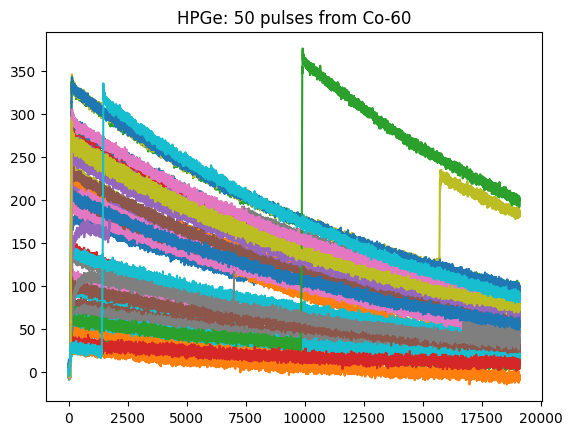

In [236]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\HPGe\Co60_120s.h5"
events = 50
XRange = 20000
preTrgrDly = 1000
Pulses(filelocation, events, XRange, preTrgrDly)
plt.title('HPGe: 50 pulses from Co-60')
plt.show()

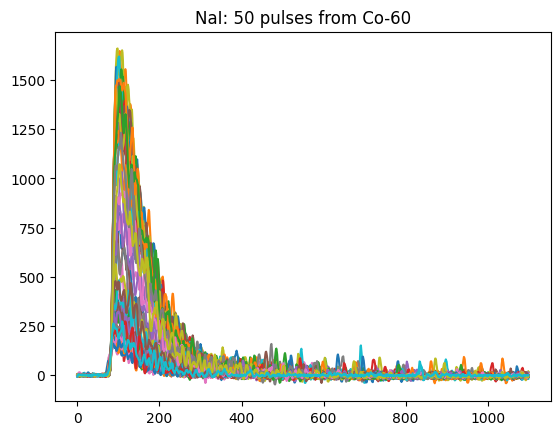

In [237]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\NaI\Co60\NaI_Co60_120s.h5"
events = 50
XRange = 2000
preTrgrDly = 1000
Pulses(filelocation, events, XRange, preTrgrDly)
plt.title('NaI: 50 pulses from Co-60')
plt.show()

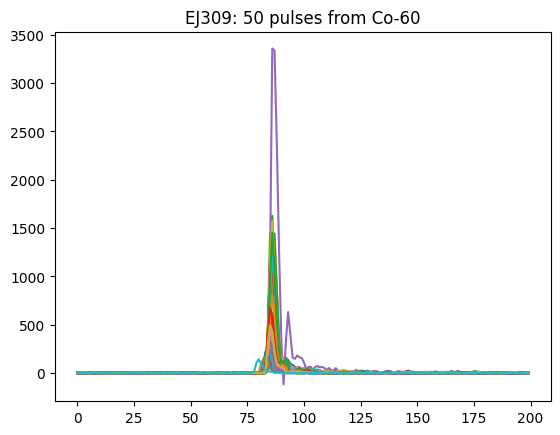

In [238]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\EJ309\EJ309_Co60_60s.h5"
events = 50
XRange = 1100
preTrgrDly = 1000
Pulses(filelocation, events, XRange, preTrgrDly)
plt.title('EJ309: 50 pulses from Co-60')
plt.show()

One can see that the length of the pulses between detectors vary by orders of magnitude. HPGe pulses have lengths of >20000, NaI lengths >200, and EJ309 > 10

# Fitting Exponential Decay to Raw Waveforms

In [239]:
def FittedPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues):
    def func(x, a, c, d):
        return a*np.exp(-c*x)+d
    with h5py.File(filelocation, 'r') as f:
        print('Decay constants are as follows')
        for a in range(0, events):
            try:
                pulse = np.array(f['raw_data'][a, :XRange])  # type: ignore
                baseline = np.average(pulse[:preTrgrDly-100])
                bpulse = []
                for b in range(XRange):
                    bpulse.append(pulse[b]-baseline)
                decay = bpulse[preTrgrDly:preTrgrDly+pulselength]
                x = np.linspace(preTrgrDly, preTrgrDly+pulselength, pulselength)
                popt, pcov = curve_fit(func, x, decay, initFitValues)
                plt.plot(bpulse[preTrgrDly-100:])
                plt.plot(x-(preTrgrDly-100), func(x, *popt))
                print(1/popt[1])
            except:
                pass

Decay constants are as follows
17078.31579179341
15492.368832792748
15233.55485460875
16199.651380535686
15632.036282590463


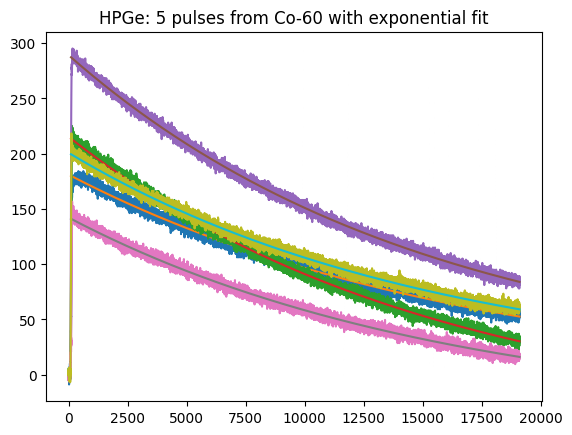

In [240]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\HPGe\Co60_120s.h5"
events = 5
XRange = 20000
pulselength = 19000
preTrgrDly = 1000
initFitValues = [1000, 0.001, 0]
FittedPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues)
plt.title('HPGe: 5 pulses from Co-60 with exponential fit')
plt.show()

Decay constants are as follows
60.24721326372374
78.67323721365784
81.71023347994598
51.536337095403645
75.92359289755701


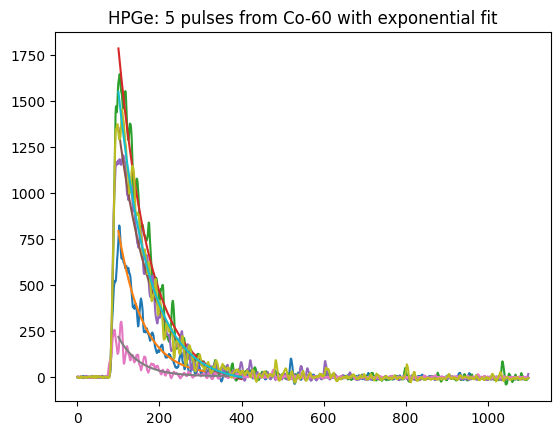

In [241]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\NaI\Co60\NaI_Co60_120s.h5"
events = 5
XRange = 2000
pulselength = 300
preTrgrDly = 1000
initFitValues = [1000, 0.001, 0]
FittedPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues)
plt.title('HPGe: 5 pulses from Co-60 with exponential fit')
plt.show()

Decay constants are as follows
1e-05
1e-05
1e-05
1e-05
1e-05


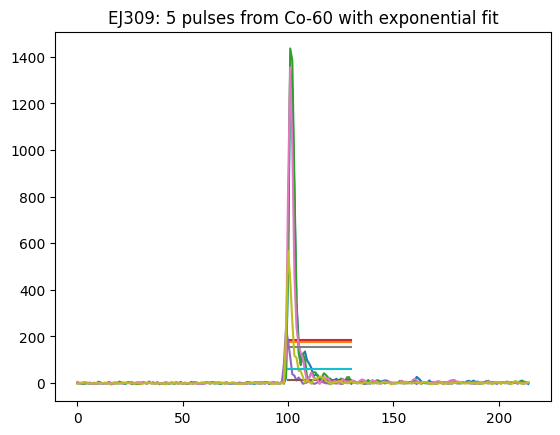

In [242]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\EJ309\EJ309_Co60_60s.h5"
events = 5
XRange = 1100
pulselength = 30
preTrgrDly = 985
initFitValues = [100000, 100000, 0]
FittedPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues)
plt.title('EJ309: 5 pulses from Co-60 with exponential fit')
plt.show()

Exponential fitting fails for data from the EJ309 due to incredibly short pulse lengths. Tried using multiple initial fit values without success. Will abandon EJ309 analysis for now.

We can see that the decay constants for the HPGe pulses are on the order of 200 times larger than the decay constants of the NaI pulses. This implies that the pulses for NaI are similarly shorter by a factor of around 200. In the previous lab we found that the optimal rise time and flat top were 1.6 and 0.8 microseconds. If these times were instead optimized for a pulse that is 200 times shorter, one would think that the optimal rise time and flat top times would also be 200 times shorter: 8 and 4 nanoseconds.

## Using Trapezoidal Filter on Waveforms

In [243]:
def FilteredPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues, risetime, flattop, poleZerofactor):
    def func(x, a, c, d):
        return a*np.exp(-c*x)+d
    with h5py.File(filelocation, 'r') as f:
        pulses = np.empty([events, 2*risetime+flattop+100])
        for a in range(events):
            try:
                pulse = np.array(f['raw_data'][a, :XRange])  # type: ignore
                baseline = np.average(pulse[:int(preTrgrDly//1.5)])
                bpulse = []
                cpulse = []
                dpulse = [0]
                for b in range(XRange):
                    bpulse.append(pulse[b]-baseline)
                decay = bpulse[preTrgrDly:preTrgrDly+pulselength]
                x = np.linspace(preTrgrDly, preTrgrDly+pulselength, pulselength)
                popt, pcov = curve_fit(func, x, decay, initFitValues)
                if 0<popt[0] and 0<popt[1]:
                    for b in range(int(preTrgrDly-50), int(preTrgrDly+2*risetime+flattop+50)):
                        if b < risetime:
                            cpulse.append(bpulse[b])
                        elif risetime <= b <= risetime+flattop-1:
                            cpulse.append(bpulse[b]-bpulse[b-risetime])
                        elif risetime+flattop <= b <= 2*risetime+flattop-1:
                            cpulse.append(bpulse[b]-bpulse[b-risetime]-bpulse[b-(risetime+flattop)])
                        else:
                            cpulse.append(bpulse[b]-bpulse[b-risetime]-bpulse[b-(risetime+flattop)]+bpulse[b-(2*risetime+flattop)])
                for b in range(1, int(2*risetime+flattop+100)):
                    dpulse.append(dpulse[b-1]*(1+poleZerofactor*popt[1])+cpulse[b])
                pulses[a]=np.array(dpulse)/risetime
            except:
                pass
        for x in range(events):
            plt.plot(pulses[x])

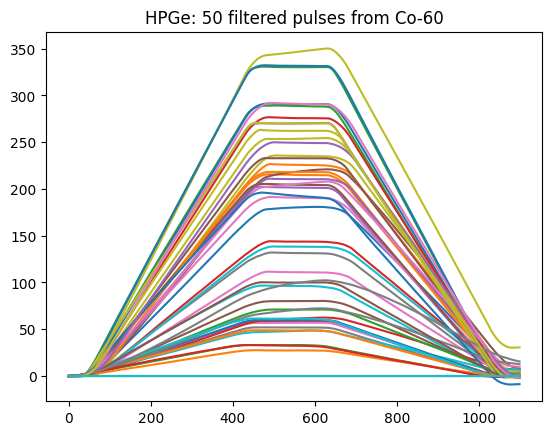

In [260]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\HPGe\Co60_120s.h5"
events = 50
XRange = 20000
pulselength = 19000
preTrgrDly = 1000
initFitValues = [1000, 0.001, 0]
risetime = 400
flattop = 200
FilteredPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues, risetime, flattop, 1)
plt.title('HPGe: 50 filtered pulses from Co-60')
plt.show()

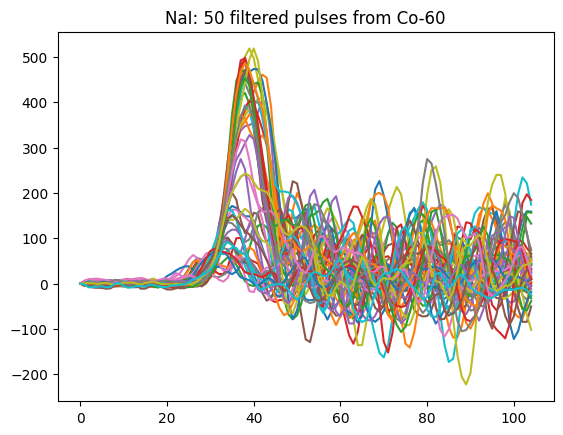

In [261]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\NaI\Co60\NaI_Co60_120s.h5"
events = 50
XRange = 2000
pulselength = 300
preTrgrDly = 1000
initFitValues = [1000, 0.001, 0]
risetime = 2
flattop = 1
FilteredPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues, risetime, flattop, 1)
plt.title('NaI: 50 filtered pulses from Co-60')
plt.show()

Using a filter with 8 and 4 nanosecond rise and gap times ends up creating this mess.

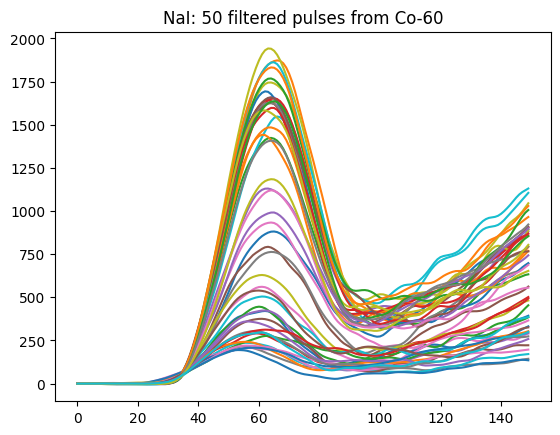

In [273]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\NaI\Co60\NaI_Co60_120s.h5"
events = 50
XRange = 2000
pulselength = 300
preTrgrDly = 1000
initFitValues = [1000, 0.001, 0]
risetime = 20
flattop = 10
FilteredPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues, risetime, flattop, 1)
plt.title('NaI: 50 filtered pulses from Co-60')
plt.show()

However, changing the rise and gap times to a larger value creates pulses that are over-corrected by the pole zero correction.

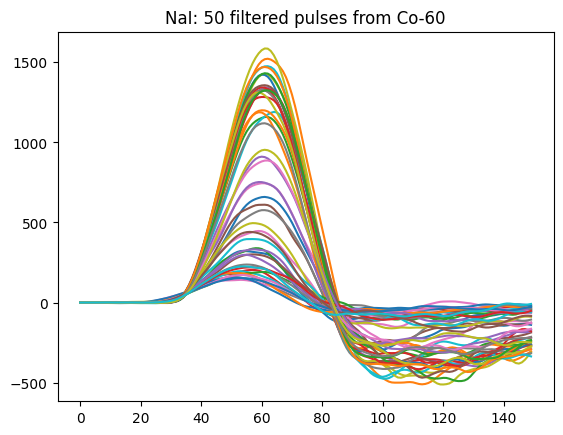

In [274]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\NaI\Co60\NaI_Co60_120s.h5"
events = 50
XRange = 2000
pulselength = 300
preTrgrDly = 1000
initFitValues = [1000, 0.001, 0]
risetime = 20
flattop = 10
poleZerofactor = 0
FilteredPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues, risetime, flattop, poleZerofactor)
plt.title('NaI: 50 filtered pulses from Co-60')
plt.show()

Here's the same rise and gap time without pole-zero correction.

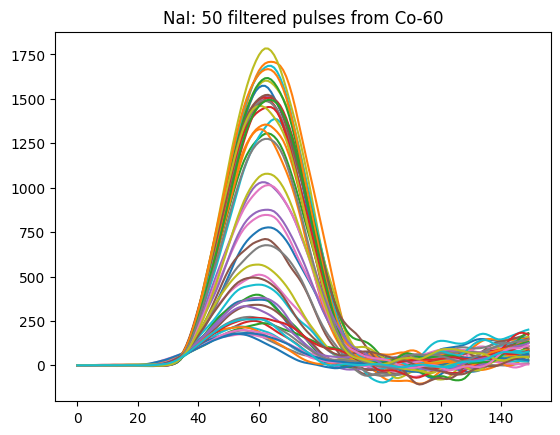

In [275]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\NaI\Co60\NaI_Co60_120s.h5"
events = 50
XRange = 2000
pulselength = 300
preTrgrDly = 1000
initFitValues = [1000, 0.001, 0]
risetime = 20
flattop = 10
poleZerofactor = 0.6
FilteredPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues, risetime, flattop, poleZerofactor)
plt.title('NaI: 50 filtered pulses from Co-60')
plt.show()

Modifying the pole-zero correction so that only 60% of the decay factor is used in the integration step of the filter will get pulses that return to about baseline (with some exponential increase further past), specifically for 80 ns rise time and 40 ns gap

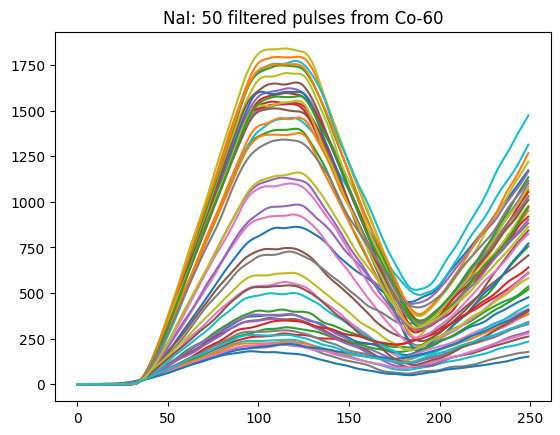

In [284]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\NaI\Co60\NaI_Co60_120s.h5"
events = 50
XRange = 2000
pulselength = 300
preTrgrDly = 1000
initFitValues = [1000, 0.001, 0]
risetime = 60
flattop = 30
poleZerofactor = 0.6
FilteredPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues, risetime, flattop, poleZerofactor)
plt.title('NaI: 50 filtered pulses from Co-60')
plt.show()

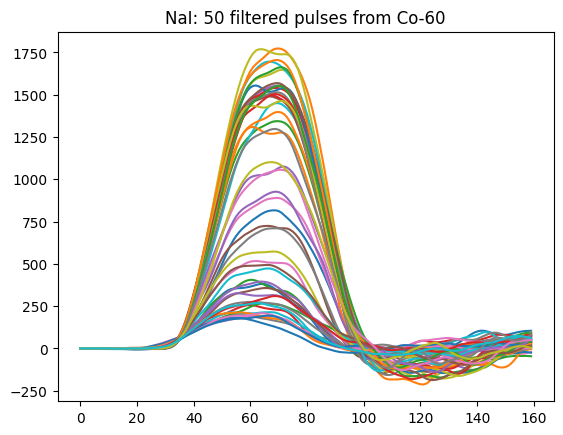

In [293]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\NaI\Co60\NaI_Co60_120s.h5"
events = 50
XRange = 2000
pulselength = 300
preTrgrDly = 1000
initFitValues = [1000, 0.001, 0]
risetime = 20
flattop = 20
poleZerofactor = 0.5
FilteredPulses(filelocation, events, XRange, pulselength, preTrgrDly, initFitValues, risetime, flattop, poleZerofactor)
plt.title('NaI: 50 filtered pulses from Co-60')
plt.show()